# Finding a solution of the PNP-equation by optimzing the pertubation parameters
As the solver guarantees electrochemical equilibrium everywhere the algorithm always finds a solution of the PNP-equations for some boundary conditions.
A shooting method is used https://en.wikipedia.org/wiki/Shooting_method.
The perturbation parameters are optimzed with the bisection algorithm until the boundary conditions are fullfilled.

Boundary conditions of Poisson equation for the full system:
    
    - Phi (0) = -70 mV
    - grad Phi(0) = 0 by rotational symmetry
    - Global electroneutrality: The total charge of the intracellular space the extracellular space and the membrane charges have to sum up to zero, i.e. grad Phi(r_ext) = 0
    - Membrane Potential: The potential drop between the central point and the exterior boundary of the extracellular space has to be -70 mV (V_exterior - V_center = -70 mV)
    
Boundary conditions for concentrations:
    
    - c^+ (0) ~ 165
    - c^- (0) ~ 10
    - c^+ (r_ext) ~ 155
    - c^- (r_ext) ~ 125
    
   
Reformulate the problem into three initial value problems and use the shooding method to find a system with the desired boundary conditions:

1: Intracellular space:

    Phi = 0 at central point (automatically fullfilled)
    grad Phi = 0 at exterior boundary (automaticall fullfilled if Q_tot = 0)
    
    c^+, c^- are well knwon ion concentrations in intracellular and intracellular space with some perturbation
    
2: Membrane
    
    - c^+, c^- = 0
    Phi as result from intracelluar space; Phi_in = Phi_mem (at mebrane boundary)
    grad Phi as result from intracelluar space; grad Phi eps_in = grad Phi eps_mem (at boundary)
    
3: Extracellular Space:

    Phi as result from membrane
    grad Phi as result from membrane
    c^+, c^- are well knwon ion concentrations in extracellular space modified by some perturbation parameter.

# Boundaries for perturbations parameters

In [1]:
import copy
import pandas as pd
import pickle
from importlib import reload

import spine_head
import spine_neck
import solve_optimize as opt


# 
import figures as fgs

In [2]:
from importlib import reload
reload(spine_head)
reload(spine_neck)

SpineHead = spine_head.SpineHead
SpineNeck = spine_neck.SpineNeck

n_digits = 9  # round to nm
# set parameters of spine domain           
d_mem = 5e-9        
# set parameters of spine domain
radius = 20 # nm
r = radius * 1e-9
r_in = str(round(r, n_digits))
r_mem = str(round(r+d_mem,n_digits))
r_out =  str(round(2*r+d_mem, n_digits))

max_repetitions = int(radius * 3)
          
                
eps_in = '50'
eps_mem = '5'
eps_out = '60'

res_in = 300
res_mem = 100
res_out = 300

# particel concentrations
c_pos_in = '175.0'
c_neg_in = '20.0'
c_back_in = '155.0'


c_pos_out = '155.00'
c_neg_out = '125.00'
c_back_out = '30.00'

# set surface charge density to -0.02 C/m^2
rho_surf_in = '-0.02'
rho_surf_out = '-0.02'

# membra
v_mem = '-0.07'



#domain = SpineNeck(r_in, eps_in, r_mem, eps_mem, r_out, eps_out)
domain = SpineHead(r_in, eps_in, r_mem, eps_mem, r_out, eps_out)
domain.set_intracellular_concentrations(c_pos_in, c_neg_in, c_back_in)
domain.set_surface_concentrations(rho_surf_in, rho_surf_out)
domain.set_extracellular_concentrations(c_pos_out, c_neg_out, c_back_out)
domain.set_membrane_potential(v_mem)



# 1. Find limits for d_phi_in and d_phi_ext

## 1.1 Point A / P_1
Intracelluar space charge compensates membrane charge on on the intracellular and extracellular space. The extracellular space is electroneutral. The system is globally electroneutral

This leads to large excess of positive charges in the intracellular space. The membrane potential is extremly high (positive; v_mem > 0). No potential drop in the extracellular space.

## 1.2 Point B / P_2

The membrane potential at the exterior side of the cell membrane is zero. the value of the potential at the center is set to the desired membrane potential e.g. -70mV or 35mV. The system is the optimzed to be globally electroneutral.

In [3]:
cpy_dm1, cpy_dm2, cpy_dm3, cpy_dm4 = copy.deepcopy(domain), copy.deepcopy(domain), copy.deepcopy(domain), copy.deepcopy(domain)

In [4]:
import gmpy2
from gmpy2 import mpfr
import matplotlib.pyplot as plt
reload(opt)
reload(fgs)
cpy_dm1 = opt.solve_domain_with_fixed_dPhi(cpy_dm1, dPhiIn=mpfr('-1') * gmpy2.exp10(-121), dPhiExt=mpfr('0'))
cpy_dm1 = opt.solve_domain_with_fixed_dPhi(cpy_dm1, dPhiIn=d_phi_in_B , dPhiExt=mpfr('-1') * gmpy2.exp10(-1))

phi = cpy_dm1.get_electric_potential()
#print(phi)

fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(phi)
ax.set_ylim(-0.2, 0.2)

plt.show()

fgs.plot_domain_overview(cpy_dm1, mask_extracellular_space=False)

NameError: name 'd_phi_in_B' is not defined

In [5]:
reload(opt)
#d_phi_in_bnds = opt.get_initial_biscetion_interval(cpy_dm1, where='in', quantity='q')
#d_phi_in_bndds = opt.get_initial_biscetion_interval(cpy_dm1, where='in', quantity='v')

Initial boundaries for bisection successfully found. (where, quantity, id)= in q 0
Initial boundaries for bisection successfully found. (where, quantity, id)= in v 0


In [6]:
reload(opt)
d_phi_in_A = opt.find_d_phi_in_A(cpy_dm1, max_repetitions=max_repetitions)
d_phi_ext_A = opt.find_d_phi_ext_A(cpy_dm2, d_phi_in=d_phi_in_A, max_repetitions=max_repetitions)
d_phi_in_B = opt.find_d_phi_in_B(cpy_dm3, max_repetitions)
d_phi_ext_B = opt.find_d_phi_ext_B(cpy_dm4, d_phi_in_B, max_repetitions) 

Initial boundaries for bisection successfully found. (where, quantity, id)= in q 0
>>>
d_phi_in successfully optimized at exterior boundary of membrane in run (ID):  0
d_phi_in:  -3.974261056702662e-11
optimisation quantity  q  =  -6.745212313386233e-34
<<<
ref 1 -1
>>>
d_phi_ext successfully optimized at exterior boundary in run (ID):  0
d_phi_ext:  -1.1383551796668135e-19
optimization quantity  q  =  -4.790349915698531e-306
<<<
Initial boundaries for bisection successfully found. (where, quantity, id)= in v 0
>>>
d_phi_in successfully optimized at exterior boundary of membrane in run (ID):  0
d_phi_in:  -2.2854469337397115e-11
optimisation quantity  v  =  2.9464901696794397e-18
<<<
ref 1 -1
>>>
d_phi_ext successfully optimized at exterior boundary in run (ID):  0
d_phi_ext:  -0.025980134047084956
optimization quantity  q  =  6.261587087460627e-23
<<<


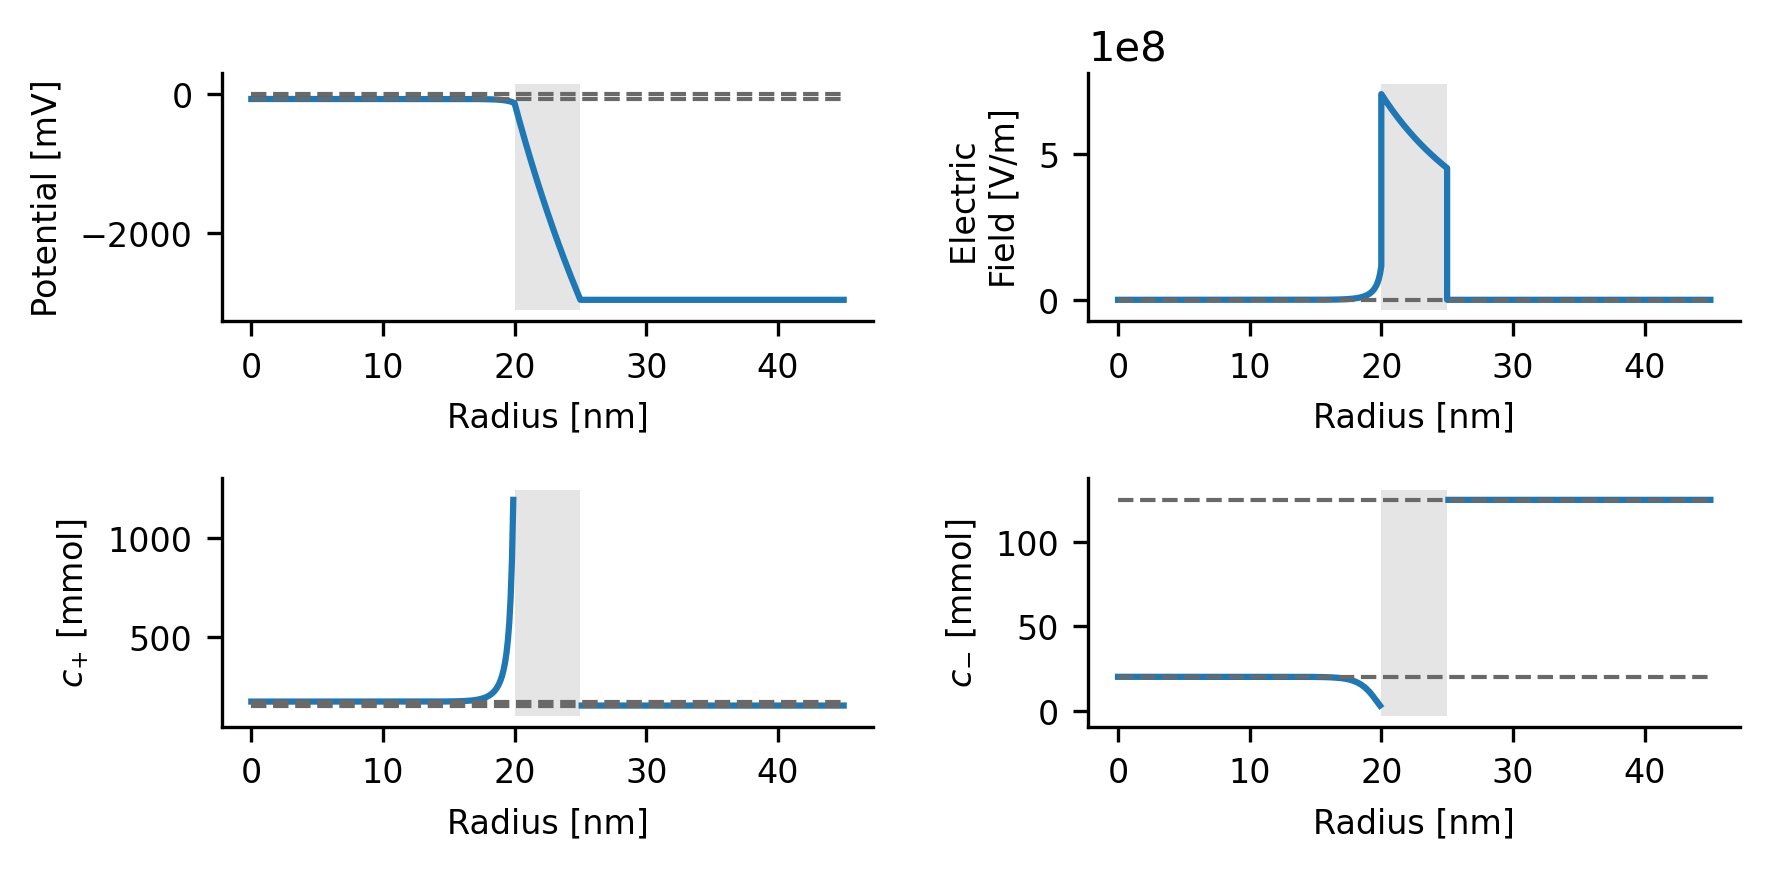

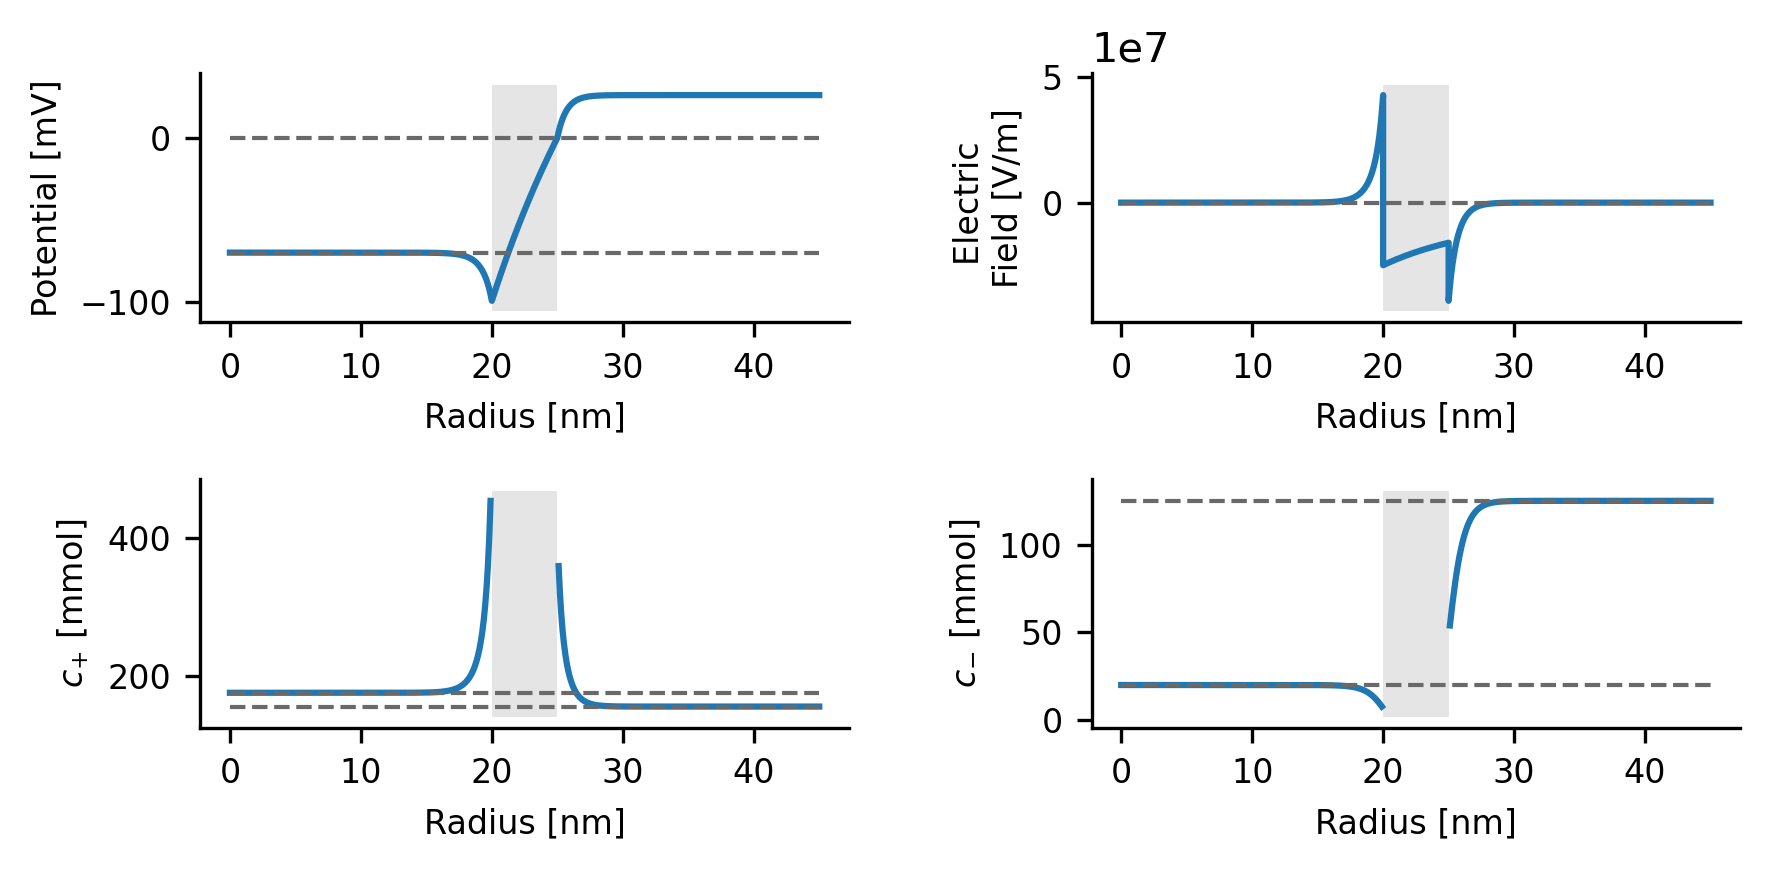

In [7]:
reload(fgs)
fgs.plot_domain_overview(cpy_dm2)
fgs.plot_domain_overview(cpy_dm4)

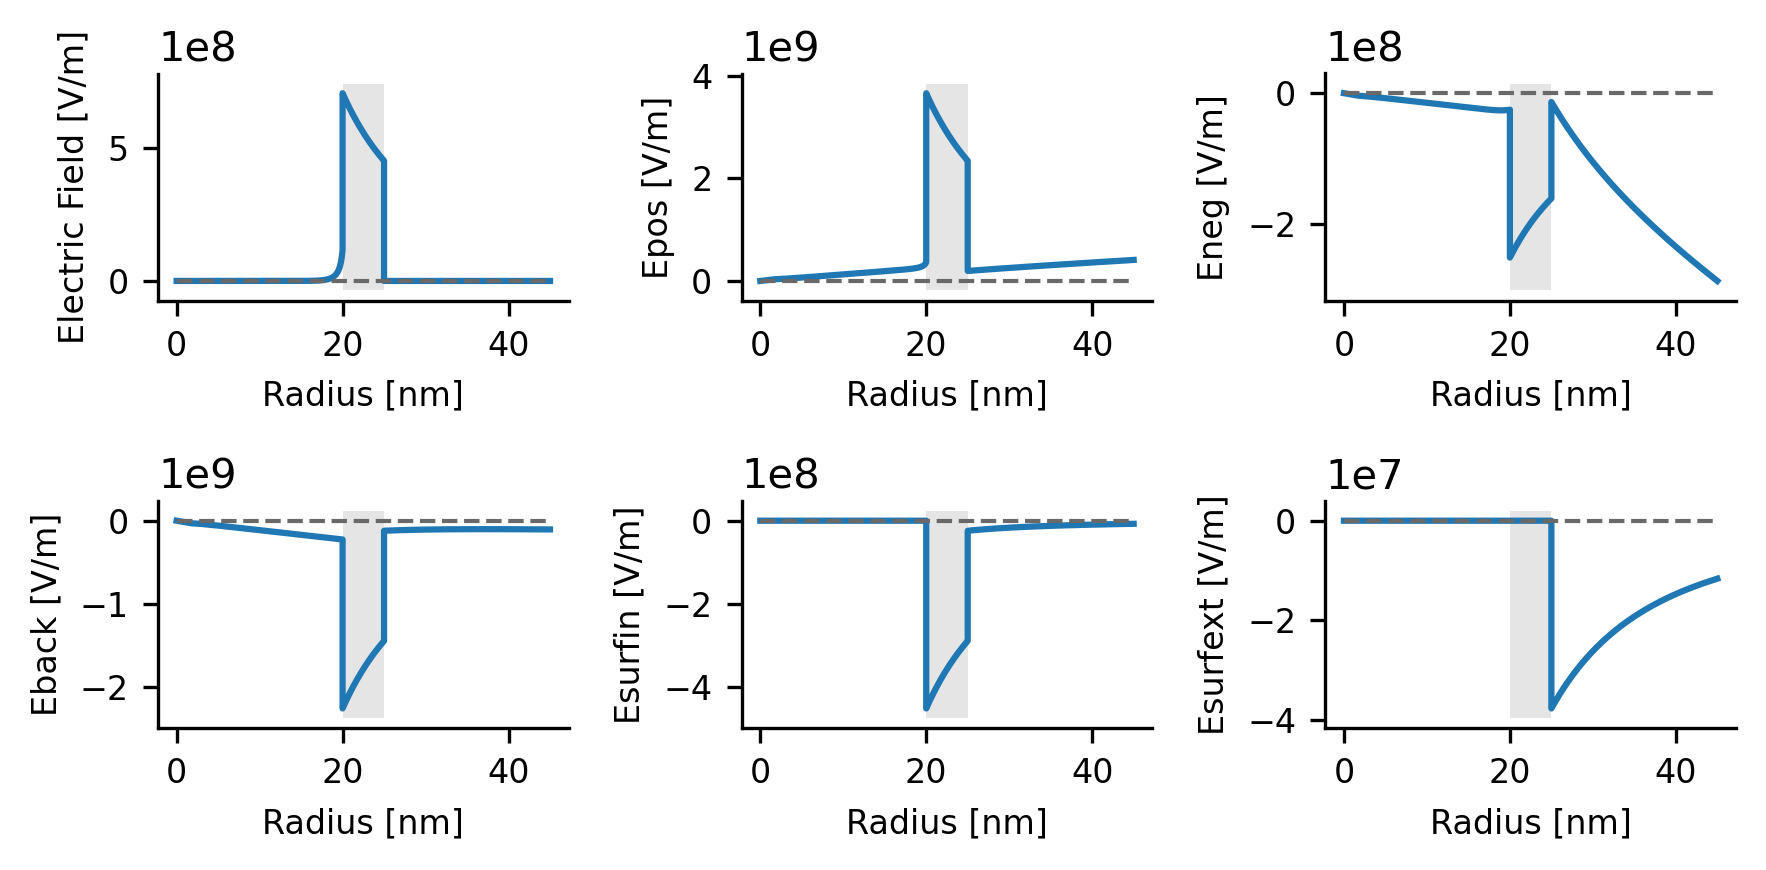

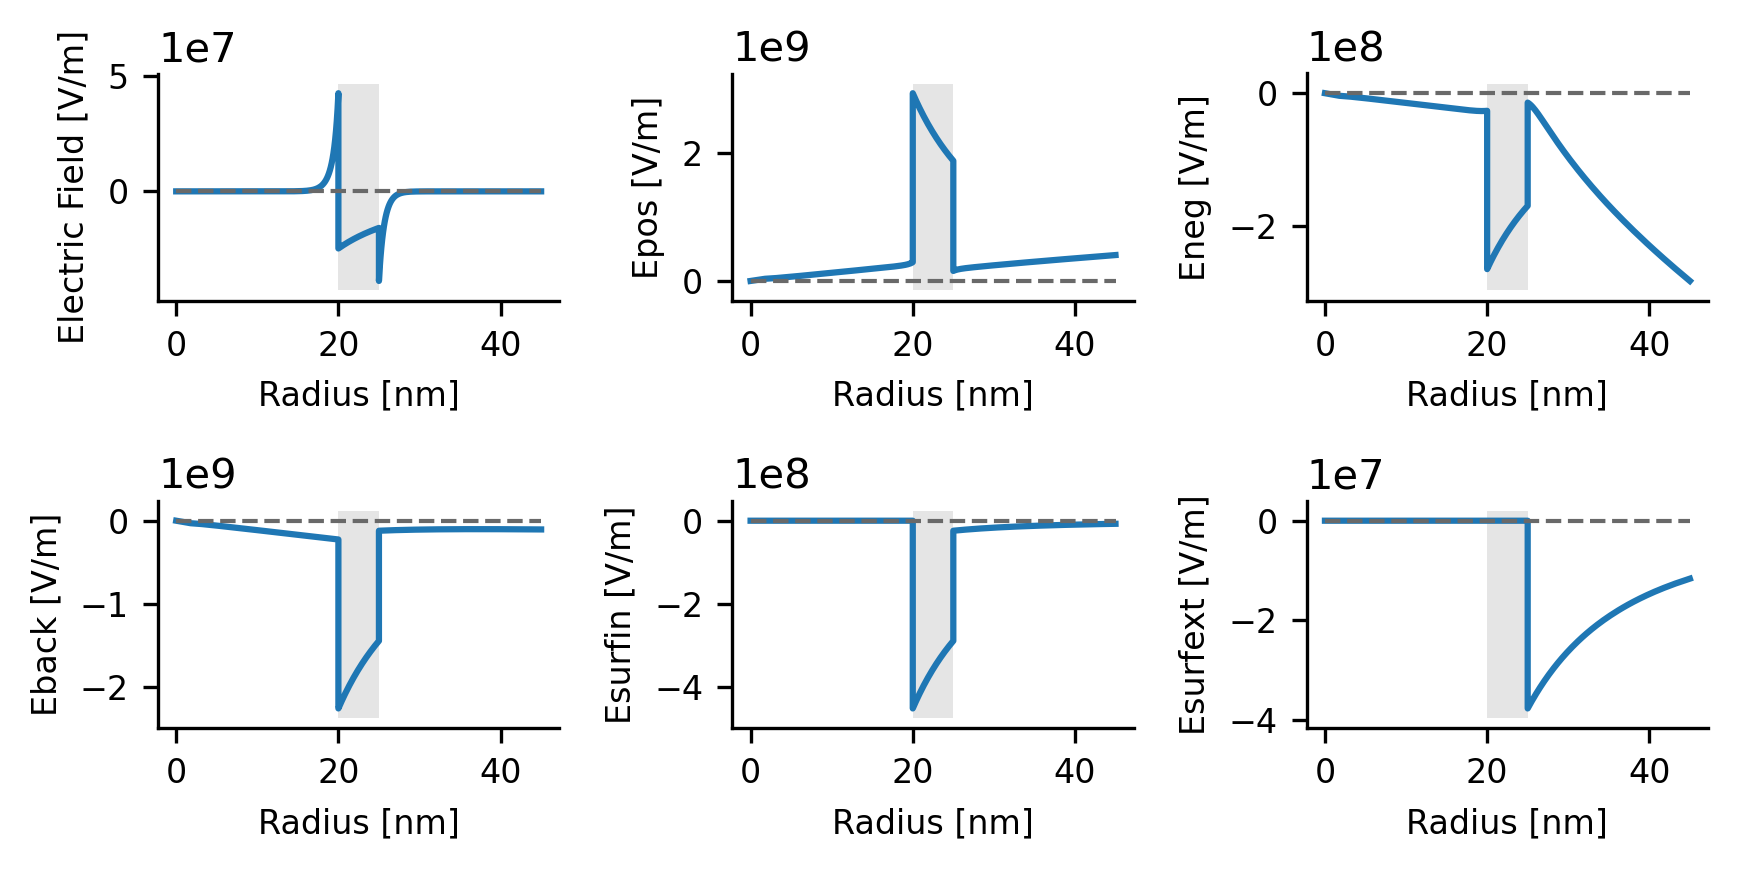

In [8]:
reload(fgs)
fgs.plot_electric_field(cpy_dm2, )
fgs.plot_electric_field(cpy_dm4, )

# Find point E

In [9]:
reload(opt)
print(float(d_phi_in_A),float(d_phi_in_B))
print(float(d_phi_ext_A),float(d_phi_ext_B))

d_phi_in_bnds = [d_phi_in_A, d_phi_in_B]
d_phi_ext_bnds = [d_phi_ext_A, d_phi_ext_B]

# is solution within those boundaries
opt.test_optimization_boundaries(domain, d_phi_in_bnds, d_phi_ext_bnds)

-3.974261056702662e-11 -2.2854469337397115e-11
-1.1383551796668135e-19 -0.025980134047084956
optimization buondaries found in domain  0


In [10]:
reload(opt)
# start 11:48:50
d_phi_in, d_phi_ext = opt.shoot(domain, d_phi_in_A, d_phi_in_B, d_phi_ext_A, d_phi_ext_B, max_repetitions, report_modulo=1)


shooting optimization: round 1 of 60 in run ID: 0
shooting optimization: round 2 of 60 in run ID: 0
shooting optimization: round 3 of 60 in run ID: 0
shooting optimization: round 4 of 60 in run ID: 0
shooting optimization: round 5 of 60 in run ID: 0
shooting optimization: round 6 of 60 in run ID: 0
shooting optimization: round 7 of 60 in run ID: 0
shooting optimization: round 8 of 60 in run ID: 0
shooting optimization: round 9 of 60 in run ID: 0
shooting optimization: round 10 of 60 in run ID: 0
shooting optimization: round 11 of 60 in run ID: 0
shooting optimization: round 12 of 60 in run ID: 0
shooting optimization: round 13 of 60 in run ID: 0
shooting optimization: round 14 of 60 in run ID: 0
shooting optimization: round 15 of 60 in run ID: 0
shooting optimization: round 16 of 60 in run ID: 0
shooting optimization: round 17 of 60 in run ID: 0
shooting optimization: round 18 of 60 in run ID: 0
shooting optimization: round 19 of 60 in run ID: 0
shooting optimization: round 20 of 60 in

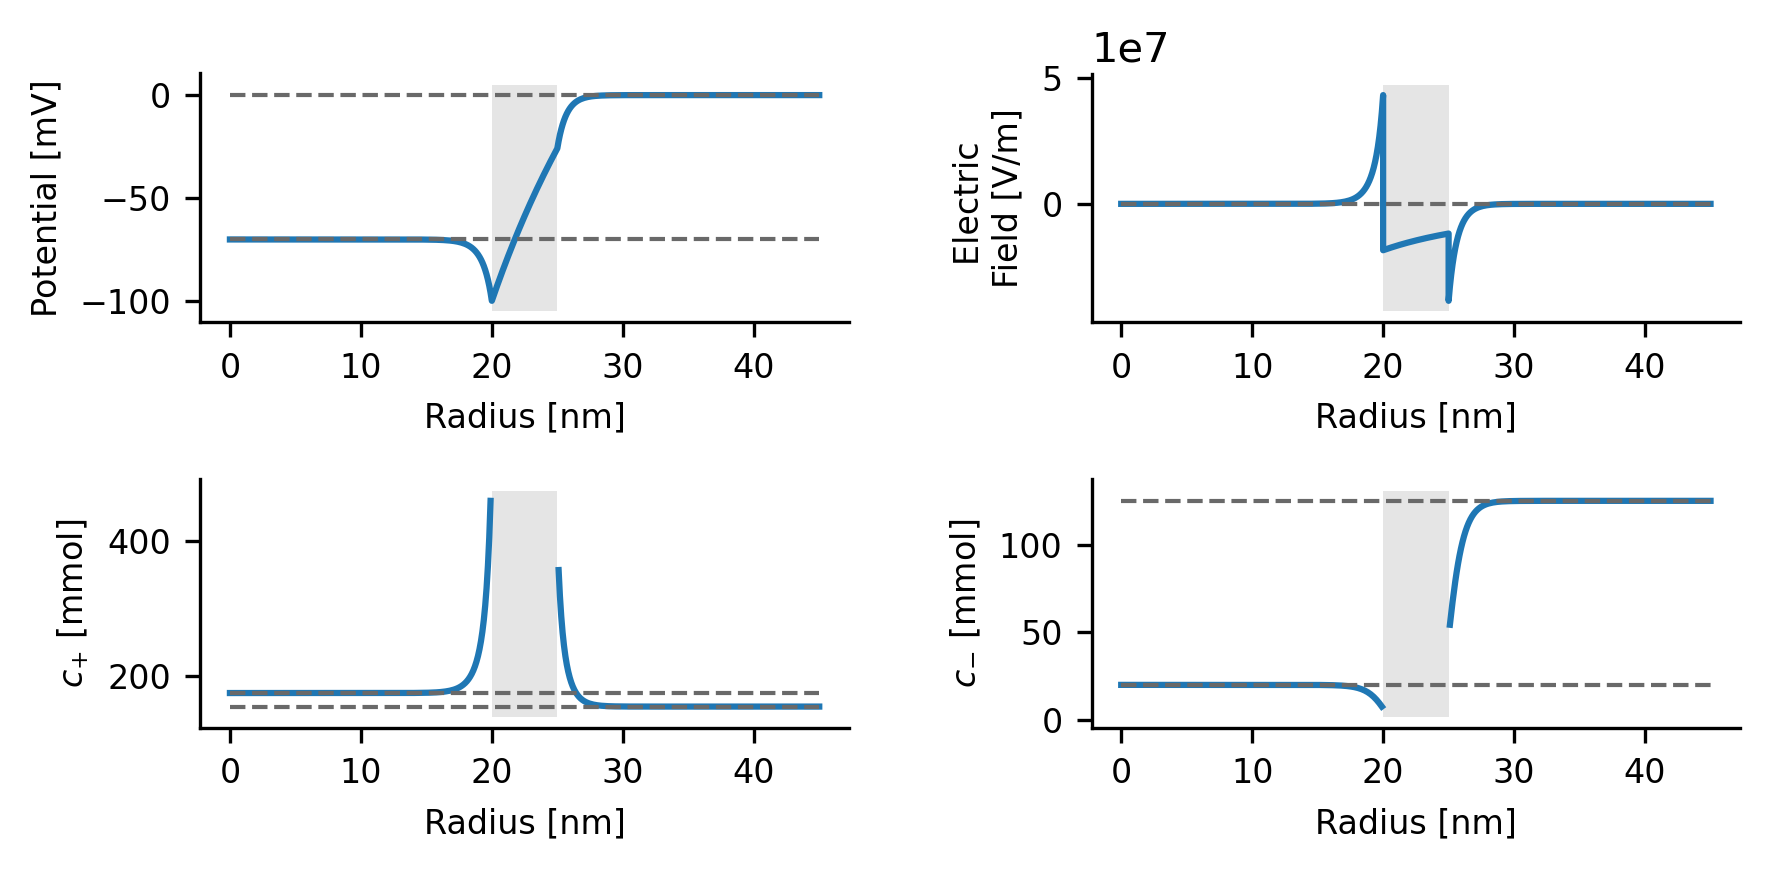

In [11]:
reload(fgs)

reload(fgs)
#domain.set_delta_phi_in(d_phi_in)
#domain.set_delta_phi_ext(d_phi_ext)
#domain.solve_domain()
fgs.plot_domain_overview(domain)

# Save domain to dataframe

In [199]:

reload(fio)
df = fio.main_results_to_pandas(spine_domain=domain, optimization_boundaries=[d_phi_in_min, d_phi_in_max, d_phi_ext_min, d_phi_ext_max])


In [29]:
df

NameError: name 'df' is not defined

In [5]:
domain2 = fio.load_domain_from_df(df, 0)
fgs.plot_domain_overview(domain2)

NameError: name 'df' is not defined

In [203]:
pickle.dump(df, open('results_df.pcl', 'wb'))